In [1]:
!pip install dtreeviz

     |████████████████████████████████| 60 kB 658 kB/s eta 0:00:01
     |████████████████████████████████| 280 kB 750 kB/s eta 0:00:01
     |████████████████████████████████| 97 kB 727 kB/s eta 0:00:01
  Created wheel for dtreeviz: filename=dtreeviz-1.3-py3-none-any.whl size=66638 sha256=8d5061c0a9af303d6f0083ad259c5e3c8afdf1fd8b1c52b597eae1b6a6fdbcf1
  Stored in directory: /home/martin/.cache/pip/wheels/37/35/0b/90a432df982480b9285addd983d37ab7e53ba75481047b7310
Successfully built dtreeviz


In [2]:
# box cox transform
from scipy.stats import boxcox
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import GradientBoostingRegressor
import numpy as np

The data, descriptions of the variables and some examples can be found here:
[house-pricese-from-kaggle-competition](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data)

In [3]:
!pwd

/home/martin/python/fhnw_lecture/notebooks


### data is from a kaggle-competition
Attention, the test data-set has no target; This is the part you are supposed to upload to kaggle for estimation of your modelling performance;

In [4]:
train = pd.read_csv('../data/train.csv', sep=",")
test = pd.read_csv('../data/test.csv')

train_ID = train['Id']
test_ID = test['Id']

train.drop('Id', axis = 1, inplace = True)
test.drop('Id', axis = 1, inplace = True)

SalePrice = train['SalePrice']
train.drop('SalePrice', axis=1, inplace = True)

### now, we want data-leakage
We discussed at length, that train and test-set should be standardized and preprocessed independently; This is only true if we want a fair estimate about our algorithm's performance with new, unseen data.<br>
In the current case we want our training-procedure to be biased towards the test-set, because the test-set performance is what counts in kaggle-competitions.

In [5]:
data = pd.concat((train, test))
data.reset_index(drop = True, inplace = True)
# categorical and numericalvariables:

categorical = [var for var in train.columns if train[var].dtype=='O']
numerical = [var for var in train.columns if train[var].dtype!='O']

# Some preprocessing steps
### we fill missing values with the mean and add an extra variable indicating the missing position

In [6]:
data[categorical] = data[categorical].fillna('None')


## next, we substitute missing values with the mean of the variable and form new variables
## indicating the missing values. Sometimes data is not missing at random and the fact that
## data is missing might contain valuable information
variables_na = []
for val in numerical:
    data[val + '_na'] = pd.isnull(data[val])
    variables_na.append(val + '_na')
    data[val].fillna(data[val].mean(), inplace = True)


### we transform the continuous variables to be more normally distributed
[box-cox transform in short](https://www.statisticshowto.com/box-cox-transformation/#:~:text=A%20Box%20Cox%20transformation%20is,a%20broader%20number%20of%20tests.)

In [7]:
## box-cox transform is variance stabilizing. It is meant to make 
## the variable more normaly distributed    
box_cox = []
for val in numerical:
    new_vals, lamb = boxcox(data[val] + 1)
    if np.abs(lamb) < 8:
        data[val + '_box_cox'] = new_vals
        box_cox.append(val)

        

/home/martin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:2116: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
/home/martin/miniconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:2115: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)


### we demonstrate the effect of the box-cox transform

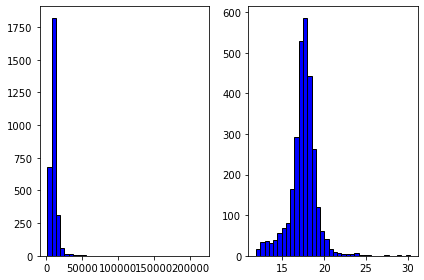

In [8]:
from matplotlib import pyplot as plt
var = 'LotArea'
# 2 fitures
ax = plt.subplot(1, 2, 1)
# non-transformed variable    
ax.hist(data[var], bins = int(180/5),
         color = 'blue', edgecolor = 'black')

ax = plt.subplot(1, 2, 2)
# transformed_variable
ax.hist(data[var + '_box_cox'], bins = int(180/5),
         color = 'blue', edgecolor = 'black')
plt.tight_layout()
plt.show()

### we encode categorical data as dummy-variables (aka one-hot encoding)

In [9]:
# as already announced, categorical data is one-hot encoded (dummy-coded)  

data_base = pd.get_dummies(data[[col for col in data.columns if col not in variables_na]])
data_na = pd.get_dummies(data[variables_na])

# we have to cast every variable's data type to float32 for our next 'trick' 
data_base = data_base.astype(np.float32)
data_na = data_na.astype(np.float32)
data_numerical = data[numerical]

data = pd.concat([data_base, data_na], axis = 1)

### we compute the feature importance in order to get the most relevant variable

In [10]:
# the number of variables is quiet high. We want to add interaction terms for the most important
# variables. Therefore, we want to compute some variable-importance measure. This is
# done by the help of gradient boosted trees:
gbm = GradientBoostingRegressor(n_estimators = 32, max_depth = 4)
gbm.fit(data.iloc[0:len(train_ID)].values, SalePrice.values)

GradientBoostingRegressor(max_depth=4, n_estimators=32)

In [11]:
from sklearn.inspection import permutation_importance

# we sort the variables (indizes) by variable importance
indizes = np.argsort(gbm.feature_importances_)
result = permutation_importance(gbm, data.iloc[0:len(train_ID)], SalePrice, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

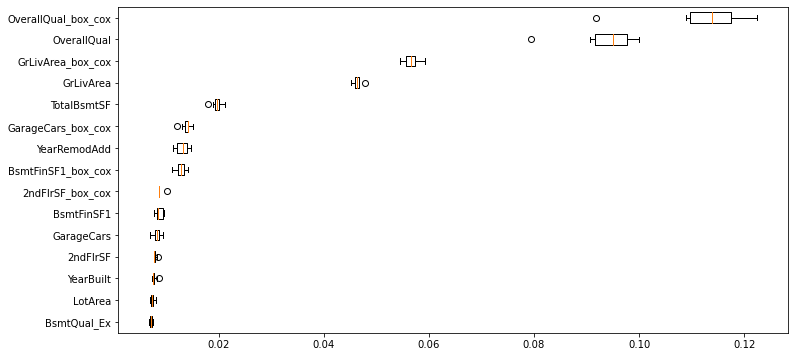

In [12]:
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 1, 1)
plt.boxplot(result.importances[sorted_idx[-15:]].T,
            vert=False, labels=np.array(data.columns)[sorted_idx[-15:]])
fig.show()

## for the most important features we compute the interactions
### in the first step we include only the most important 15 variables to form interaction-terms

In [13]:
# import a tool for getting all possible n over 2 combinations of these variables
from itertools import combinations
# and add the interactions
interactions = []
for comb in list(combinations(data.columns[sorted_idx[-15:]], 2)):
    data[comb[0] + '_x_' + comb[1]] = data[comb[0]] * data[comb[1]]
    interactions.append(comb[0] + '_x_' + comb[1])

data_interactions = data[interactions]

### in the second step we include even 55 variables to form interactions

In [14]:
interactions2 = []
for comb in list(combinations(data.columns[sorted_idx[-55:]], 2)):
    data[comb[0] + '_x_' + comb[1]] = data[comb[0]] * data[comb[1]]
    interactions2.append(comb[0] + '_x_' + comb[1])

data_interactions2 = data[interactions2]

In [15]:
## 1.
# now, we have different data sets
# the base set with missing values imputed by the mean and no other feature engineering
# box-cox transformed variables are removen
base = data_base[[col for col in data_base.columns if not col.endswith('_box_cox')]]
## 2.
# box_cox is admitted; original variables removed
with_box_cox = data_base[[col for col in data_base.columns if not col in box_cox]]
## 3.
# variables indicating formerly missing values are included
with_na = pd.concat([with_box_cox, data_na], axis = 1)
## 4.
# all interaction terms of the 55 most important variables are added
with_interactions = pd.concat([with_na, data_interactions], axis = 1)
## 5.
## we exagerate the number of interactions
with_interactions2 = pd.concat([with_na, data_interactions2], axis=1)
## the target variable is log-transformed
y = np.log1p(SalePrice)

## since we want to try elasticnet, we have to find the optimal parameter for 
# lambda (amount of regularization) and for alpha (ratio of lasso and ridge mixing)
lamb = 10**(np.linspace(-1, 0.2, 15))
# ratio
ratio = np.linspace(0, 1, 10)

### excurs: parameter sampling on a logarithmic scale

sample some of the parameters on a logrithmic scale:
https://www.coursera.org/lecture/deep-neural-network/using-an-appropriate-scale-to-pick-hyperparameters-3rdqN

In [16]:
np.linspace(0.0001, 0.1, 5) # 5 equally spaced values from 0.0001 to 0.1

array([0.0001  , 0.025075, 0.05005 , 0.075025, 0.1     ])

As you can see, there is no value between 0.0001 and 0.001 and no value between 0.001 and 0.01. But there are three values between 0.01 and 0.1<br>
Now, compare to this solution:

In [17]:
10**np.linspace(-4, -1, 5)

array([0.0001    , 0.00056234, 0.00316228, 0.01778279, 0.1       ])

### we transform the SalePrice (y) as well

In [18]:
# the function np.log1p is well defined at 0
display(np.log(0), np.log(1), np.log(2),
        np.log1p(1), np.log1p(0))

/home/martin/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


-inf

0.0

0.6931471805599453

0.6931471805599453

0.0

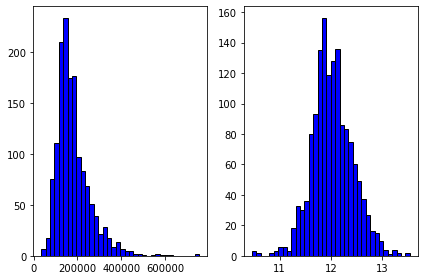

In [19]:
var = 'LotArea'
# 2 fitures
ax = plt.subplot(1, 2, 1)
# non-transformed variable    
ax.hist(SalePrice, bins = int(180/5),
         color = 'blue', edgecolor = 'black')

ax = plt.subplot(1, 2, 2)
# transformed_variable
ax.hist(np.log1p(SalePrice), bins = int(180/5),
         color = 'blue', edgecolor = 'black')
plt.tight_layout()
plt.show()

In [20]:
error = []
best_parameters = []
# we iterate over list of data-sets
for d in [base, with_box_cox, with_na, with_interactions, with_interactions2]:
    # scale variables
    scaler = StandardScaler()
    scaler.fit(d[:len(train_ID)]) #  fit  the scale        

    X_train = scaler.transform(d[:len(train_ID)])
    X_test = scaler.transform(d[len(train_ID):])
    
    # the function cross_val_score computes the model passed to it for cv=5-fold 
    # cross validation; we compute the mean over the 5 folds
    get_results = [(l, r, np.mean(np.sqrt(-cross_val_score(ElasticNet(alpha = l,
                                                            l1_ratio = r),
            X_train, y , scoring = 'neg_mean_squared_error',
            cv = 5, n_jobs = -1))))
                for l in lamb for r in ratio]
    
    # the least error is extracted
    least_error = np.min([i[2] for i in get_results])
    error.append(least_error)
    # the parameters belonging to the best result
    parameters = [i[0:2] for i in get_results if i[2] == least_error]
    best_parameters.append(parameters)
    print(f'least error is: {least_error}, best parameters are: {parameters}')


least error is: 0.1382281067080659, best parameters are: [(0.3981071705534972, 0.0)]
least error is: 0.13065758654150422, best parameters are: [(0.1, 0.1111111111111111)]
least error is: 0.13065758650403755, best parameters are: [(0.1, 0.1111111111111111)]
least error is: 0.12822409569904014, best parameters are: [(0.12181879120101156, 0.0)]


/home/martin/miniconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


least error is: 0.12375202050910084, best parameters are: [(0.4849693428528198, 0.0)]


In [25]:
best_parameters

[[(0.3981071705534972, 0.0)],
 [(0.1, 0.1111111111111111)],
 [(0.1, 0.1111111111111111)],
 [(0.12181879120101156, 0.0)],
 [(0.4849693428528198, 0.0)]]

In [26]:
display(base.shape, with_box_cox.shape, with_na.shape, with_interactions.shape, with_interactions2.shape)

(2919, 310)

(2919, 310)

(2919, 346)

(2919, 451)

(2919, 1831)

We conclude:
1. The error for the base data set (only missing values imputed) is: {{np.round(error[0], 4)}}  (mse); The corresponding lambda is {{np.round(best_parameters[0][0][0], 4)}}, i.e. the amount of regularization; the l1_ratio = {{np.round(best_parameters[0][0][1], 4)}}; the kind of regularization was pure ridge (l2-penalty)
2. The error with some of the numeric variables box-cox transformed is {{np.round(error[1], 4)}} (mse); the amount of regularization is far less than before ({{np.round(best_parameters[1][0][0], 4)}}); we have {{np.round(best_parameters[1][0][1] * 100)}}% l1-penalty and {{np.round(100 - (best_parameters[1][0][1] * 100))}}% l2-penalty
3. Indicator variables for formerly missing values are included in the data-set; The error ({{np.round(error[2], 4)}}) shrinks by an insignificant amount. The lambda parameter is {{np.round(best_parameters[2][0][0], 4)}}; no l1-penalty is used
4. adding the interaction terms has the most pronounced effect. The error drops to {{np.round(error[3], 4)}}; The best parameters are as before.

In [27]:
len(train_ID)

1460

One additional note: By including the interaction2 terms, we have __more variables (1831) than observations (1460)__ in the training set. This situation is not admissable in classical statistics. For machine learning algorithms with regularization and/or iterative optimization, it does not mean any problem.

We now have found the best parameters by cross-validation. Now, we try to solve a business problem with these results:<br>
__The sales team needs all houses from the test set with estimated prices higher than 350'000\$. Can you please deliver an estimate about how accurate your predictions are?__ (again we are allowed to be biased towards the test-set)<br>
1. Compute the confidence intervals for the test-set.
We proceed as follows:
2. Obtain estimates for the train-set by splitting the train-set in k=5 folds and always train on 4 folds and make predictions on the 5th fold. We obtain CIs in this manner.
3. We take the lower-bounds of the confidence intervals. This ensures, that we do not include cases (houses) with very unstable estimates.
4. Since we trained the CIs for the training-set with cross-validation, we can treat them as an estimate for the accuracy of the CIs of the test-set: This gives us an estimate of the error we make.

In [28]:
import warnings
from random import choices
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold # import KFold
warnings.filterwarnings('ignore')
# we get a lot of warnings:
# LinAlgWarning: Ill-conditioned matrix (rcond=1.80167e-08): result may not be accurate.
#  overwrite_a=False)
# this is because we use more variables than observations and we get the already discussed
# problems with matrix inversion


scaler = StandardScaler()
scaler.fit(with_interactions) #  fit  the scale        


X = scaler.transform(with_interactions[:len(train_ID)])
test = scaler.transform(with_interactions[len(train_ID):])

## 1.
indices = np.arange(0, X.shape[0])
# draw 200 samples with replacement from training data set
sampler = (choices(indices, k = len(indices)) for i in range(200))
# fit 200 models to the samples drawn and predict on test-set
# 
CIS_test = np.percentile(
            np.array(
                [
                 Ridge(alpha=best_parameters[-2][0][0], fit_intercept=True)\
                 .fit(X[drew,:], y.values[drew]).predict(test).tolist()
                 for drew in sampler]
                 ), [2.5, 97.5], axis = 0)


## 2.
kf = KFold(n_splits = 5, shuffle=True)
CIS = np.empty((2, X.shape[0]))
y_hat = np.empty((y.shape[0],))
for train_index, test_index in kf.split(X):
    X_train = X[train_index,:]
    y_train = y[train_index]
    X_test = X[test_index, :]
    y_test = y[test_index]
    indices = np.arange(0, X_train.shape[0])

    sampler = (choices(indices, k = len(indices)) for i in range(200))
    CIS[:, test_index] = np.percentile(
        np.array(
            [
             Ridge(alpha=best_parameters[-1][0][0], fit_intercept=True)\
             .fit(X_train[drew,:], y_train.values[drew])\
                              .predict(X_test).tolist()
             for drew in sampler]
             ), [2.5, 97.5], axis = 0)


In [29]:
## 3.
bool_indizes = np.exp(CIS_test[0, :]) - 1 > 350000
sum(bool_indizes)
for_sales_departement = list(
    zip(np.arange(0, CIS_test.shape[1])[bool_indizes], np.exp(CIS_test[0, bool_indizes])+1)
)


In [30]:
y_hat_lower = np.exp(CIS[0,:])-1
estimates = y_hat_lower > 350000
true = (np.exp(y) +1) > 350000
y_hat_lower[estimates]
print(f'we estimate that {np.round(np.mean(true[estimates]) * 100, 2)}% of our predictions are correct')
print(f'\nhowever, we only got {np.round(sum(true[estimates])/sum(true)*100, 2)}% of all houses with prices higher than 350000')


we estimate that 90.48% of our predictions are correct

however, we only got 33.93% of all houses with prices higher than 350000


## Now, suppose
the sales team wants to use your algorith for new incoming houses. How good can we predict theses houses?

__Question:__ What is the most accurate method to get a good estimate? In the example before, we fitted each statistic on the whole training-set. Is this a good idea to get an estimate about how the algorithm will perform on unseen data?

__Exercise:__ get the estimates right by help of python Pipelines

In [31]:
!pwd

/home/martin/python/fhnw_lecture/notebooks


In [32]:
import pandas as pd

One-hot encoding and adding variables for missing values is not critical: no statistics are fitted<br>

we load the data (only train) once again:

In [33]:
train = pd.read_csv('../data/train.csv', sep=",")
train_ID = train['Id']
train.drop('Id', axis = 1, inplace = True)
SalePrice = train['SalePrice']
train.drop('SalePrice', axis=1, inplace = True)
categorical = [var for var in train.columns if train[var].dtype=='O']
numerical = [var for var in train.columns if train[var].dtype!='O']

Next we add an indicator variable for every missing value: no statistics are fitted:

In [34]:
train[categorical] = train[categorical].fillna('None')
for val in numerical:
    train[val + '_na'] = pd.isnull(train[val])

the follwing statistics however, depend on the data:<br>
- filling NAs with mean-values
- box-cox transform of variable
- computing the best features and forming interaction variables
- fitting the model

For this task, please use the custom-function InteractionsTransformer provided in the file interactions_transformer.py; 

In [ ]:
import sys
import os
import numpy as np
sys.path.append(os.path.abspath('../scripts'))
from interactions_transformer import InteractionsTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

numeric_features = numerical
categorical_features = categorical

# please use for these steps SimpleImputer and PowerTransform -> look it up in the internet
numeric_transformer = Pipeline(steps=[
                                     ])
# one-hot encode (dummy encode) the categorical variables with OneHotEncoder
categorical_transformer = 

# the ColumnTransformer combines the numeric_transformer and the categorical_transformer
preprocessor = 

# use GridSearchCV, combine the preprocessor, InteractionsTransformer an ElasticNet within make_pipeline
clf = GridSearchCV(
            ,
            param_grid={'elasticnet__alpha': 10**(np.linspace(-1, 0.2, 5)),
                        'elasticnet__l1_ratio': np.linspace(0, 1, 6)},
         cv=5, refit=False, scoring = 'neg_mean_squared_error'
)


In [69]:
import sys
import os
import numpy as np
sys.path.append(os.path.abspath('../scripts'))
from interactions_transformer import InteractionsTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder


numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
    ('scaler', PowerTransformer(method='box-cox'))])

categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse=False)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical),
        ('cat', categorical_transformer, categorical),
        ])

clf = GridSearchCV(
        make_pipeline(
            preprocessor,
            InteractionsTransformer(),
            ElasticNet()
            ),
            param_grid={'elasticnet__alpha': 10**(np.linspace(-1, 0.2, 5)),
                        'elasticnet__l1_ratio': np.linspace(0, 1, 6)},
         cv=5, refit=False, scoring = 'neg_mean_squared_error'
)


starting feature importance


In [70]:
train[numerical] += 1
clf.fit(train, np.log1p(SalePrice))

starting feature importance
starting feature importance
starting feature importance
starting feature importance
starting feature importance
starting feature importance
starting feature importance
starting feature importance
starting feature importance
starting feature importance
starting feature importance
starting feature importance
starting feature importance
starting feature importance
starting feature importance
starting feature importance
starting feature importance
starting feature importance
starting feature importance
starting feature importance
starting feature importance
starting feature importance
starting feature importance
starting feature importance
starting feature importance
starting feature importance
starting feature importance
starting feature importance
starting feature importance
starting feature importance
starting feature importance
starting feature importance
starting feature importance
starting feature importance
starting feature importance
starting feature imp

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          PowerTransformer(method='box-cox'))]),
                                                                         ['MSSubClass',
                                                                          'LotFrontage',
                                                                          'LotArea',
                                                                          'OverallQual',
                                                   

In [71]:
display(clf.best_params_, np.sqrt(-clf.best_score_))
# clf.cv_results_.keys()

{'elasticnet__alpha': 0.1, 'elasticnet__l1_ratio': 0.0}

0.12478130060340616

In [72]:
clf.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_elasticnet__alpha', 'param_elasticnet__l1_ratio', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])

In [73]:
np.sqrt(-clf.cv_results_['mean_test_score'])

array([0.1247813 , 0.14769876, 0.16453242, 0.18267359, 0.19985306,
       0.21528227, 0.12948769, 0.16705808, 0.20169271, 0.23435203,
       0.26753428, 0.299449  , 0.13458011, 0.20678027, 0.27600369,
       0.33904176, 0.39445307, 0.39954338, 0.14411109, 0.28669422,
       0.39540082, 0.39954338, 0.39954338, 0.39954338, 0.15495452,
       0.39657224, 0.39954338, 0.39954338, 0.39954338, 0.39954338])

Now, we have to get the confidence intervalas CIs

In [74]:
from sklearn.model_selection import KFold # import KFold
from random import choices
train[numerical] += 1

kf = KFold(n_splits = 5, shuffle=True)
CIS = np.empty((2, train.shape[0]))
y_hat = np.empty((SalePrice.shape[0],))
for train_index, test_index in kf.split(train):
    X_train = train.iloc[train_index,:]
    y_train = np.log1p(SalePrice)[train_index]
    X_test = train.iloc[test_index, :]
    y_test = np.log1p(SalePrice)[test_index]
    indices = np.arange(0, X_train.shape[0])

    custom_pipeline = make_pipeline(
            preprocessor,
            InteractionsTransformer(),
            ElasticNet().set_params(alpha=clf.best_params_['elasticnet__alpha'],
                                   l1_ratio=clf.best_params_['elasticnet__l1_ratio']))
    sampler = (choices(indices, k = len(indices)) for i in range(200))
    runs = []
    for drew in sampler:
        try:
            runs.append(custom_pipeline.\
             fit(X_train.iloc[drew, :], y_train.iloc[drew]).predict(X_test).tolist()
                       )
        except:
            pass
            
    CIS[:, test_index] = np.percentile(np.array(runs), [2.5, 97.5], axis = 0)

starting feature importance
starting feature importance
starting feature importance
starting feature importance
starting feature importance


In [21]:
y_hat_lower = np.exp(CIS[0,:]) - 1
estimates = y_hat_lower > 350000
true = SalePrice > 350000
y_hat_lower[estimates]
print(f'we estimate that {np.round(np.mean(true[estimates]) * 100, 2)}% of our predictions are correct')
print(f'\nhowever, we only get {np.round(sum(estimates)/sum(true)*100, 2)}% of all houses with prices higher than 350000')


we estimate that 90.91% of our predictions are correct

however, we only got 40.74% of all houses with prices higher than 350000


# Reminder
We found the best parameters via extensive search over the whole data-set. As we have discussed, theoretically double-cross-validation would have been the better choice. However, it would also be computationally more expensive.